## Final Project Submission

Please fill out:
* Student name: Eric Sundstrom
* Student pace: part time
* Scheduled project review date/time: Tuesday 5/15 2:00 EST
* Instructor name: Victor Geislinger
* Blog post URL: https://swede0623.github.io/module_1_project_blog_post


# OSEMN Data Science Process

# Obtain Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# Business Understanding:

Our goal is to predict the sale price of houses using the other variables provided in the data set as columns
We will be using a multivariable linear regression model
This notebook is for technical audiences

# Scrub

Is the dataset really large?  Do we need a subsample to make things easier and faster for now?

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


It doesn't look too big, much smaller than the Walmart data-set we dealt with in the labs.  I'm going to wait to see if I run into long runtimes with the full dataset before deciding if I need to take a subsample

# Dealing with Datatypes:

thankfully we're dealing with mostly numbers
the date is coded as a string (object)
sqft_basement is supposed to be a number but is coded as a string; must be changed
waterfront is probably a dummy variable
there could be some other candidates for transforming the numbers to categorical variables

There was an error when I tried to convert sqft_basement to float. There is a question mark value that is causing the error.  Maybe we can convert to float as intended if we transform the ? data to something that can be transformed to a number

In [5]:
df['sqft_basement'].value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

In [6]:
df[df['sqft_basement'] == '?'].head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
18,16000397,12/5/2014,189000.0,2,1.00,1200,9850,1.0,0.0,0.0,...,7,1200,?,1921,0.0,98002,47.3089,-122.210,1060,5095
42,7203220400,7/7/2014,861990.0,5,2.75,3595,5639,2.0,0.0,0.0,...,9,3595,?,2014,0.0,98053,47.6848,-122.016,3625,5639
79,1531000030,3/23/2015,720000.0,4,2.50,3450,39683,2.0,0.0,0.0,...,10,3450,?,2002,0.0,98010,47.3420,-122.025,3350,39750
112,2525310310,9/16/2014,272500.0,3,1.75,1540,12600,1.0,0.0,0.0,...,7,1160,?,1980,0.0,98038,47.3624,-122.031,1540,11656


The other data for rows where sqft_basement is ? seem to be valid data so we can't just disregard those rows.
We can't assume ? was used for those without a basement because we don't know.  Can't change ? to 0s because we don't know what the data already stored as 0 truly means.  Let's change it to another number like 0 so we know we have this ? data but stored as a 1 so we can convert the datatype to float to be able to make graphical use of the non 0 and 1 data points

In [7]:
df.loc[df['sqft_basement'] == '?', ['sqft_basement']] = '1.0'

In [8]:
df.sqft_basement.value_counts().head()

0.0      12826
1.0        454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

In [9]:
df.sqft_basement = df.sqft_basement.astype('float64')

In [10]:
df.sqft_basement.dtype

dtype('float64')

In [11]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


maybe floors would be better represented as categorical because of the small number of unique possibilities

In [12]:
df.floors.unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

no, let's keep as is.  with the inclusion of the 1/2 steps there is enough data points to make sense of this as a continuous variable

In [13]:
df.waterfront.unique()

array([nan,  0.,  1.])

In [14]:
df.waterfront.value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [15]:
df.waterfront.isna().sum()

2376

waterfront is a dummy variable we need to cast to a string

In [16]:
df.waterfront.dtype

dtype('float64')

In [17]:
df.waterfront = df.waterfront.astype('str')

Okay. Now let's move on to view

In [18]:
df.view.unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

In [19]:
df.view.value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

this is a strange variable.  (you would think) it's supposed to be how many times the house has been viewed but it's values only go up to 4.  doesn't really make sense.  Maybe the column was described wrong.  I guess it's just better to keep this column intact and as a continuous variable

we aren't going to change anymore columns to categorical so let's now move on to dealing with null values

only 2 columns have null data: view and yr_renovated

we already saw view is a strange variable, we don't really even know what the non-null values mean, but let's see how many null values there are

In [20]:
df.view.isna().sum()

63

there aren't many null values, the vast majority of this column's values are 0.  often times null and 0 represent the same thing.  I think we should just change the NaN values to 0

In [21]:
df.loc[df.view.isna(), 'view'] = 0.0

In [22]:
df.view.unique()

array([0., 3., 4., 2., 1.])

Okay good, now onto the null values in waterfront

In [23]:
df.waterfront.unique()

array(['nan', '0.0', '1.0'], dtype=object)

In [24]:
df.waterfront.value_counts()

0.0    19075
nan     2376
1.0      146
Name: waterfront, dtype: int64

Now I remember we encountered null (nan) values in the waterfront variable before we converted the whole thing to a string.  Should we transform the null values to 0 since they both easily could represent that the house is not waterfront property?  Or  keep the null values as a separate category for a 3 category dummy variable?

In [25]:
df.yr_renovated.unique()

array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008.,
       1968., 2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

In [26]:
df.yr_renovated.value_counts().head(10)

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
2000.0       29
2005.0       29
1990.0       22
2004.0       22
2009.0       21
Name: yr_renovated, dtype: int64

In [27]:
df.yr_renovated.isna().sum()

3842

the 0 value is probably already a placeholder for homes that have never been renovated.  17000 rows have a 0 value so we are just going to change the null values to 0, because at the end of the day, if we don't know what year it was renovated then it is of no use to us in this column besides being something other than a year of renovation

In [28]:
df.loc[df.yr_renovated.isna(), 'yr_renovated'] = 0.0

In [29]:
df.yr_renovated.isna().sum()

0

Okay, we have removed all of the (technically) null data from our dataset.  Time for the next step

In [30]:
df.zipcode.unique()

array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039], dtype=int64)

zipcodes are really more like categories because higher and lower numbers as your zipcode doesn't really mean anything (I don't think).  but a 70 category variable seems like a bad idea

# Explore

Let's check for multi-collinearity between our variables as that would be a big problem for our model

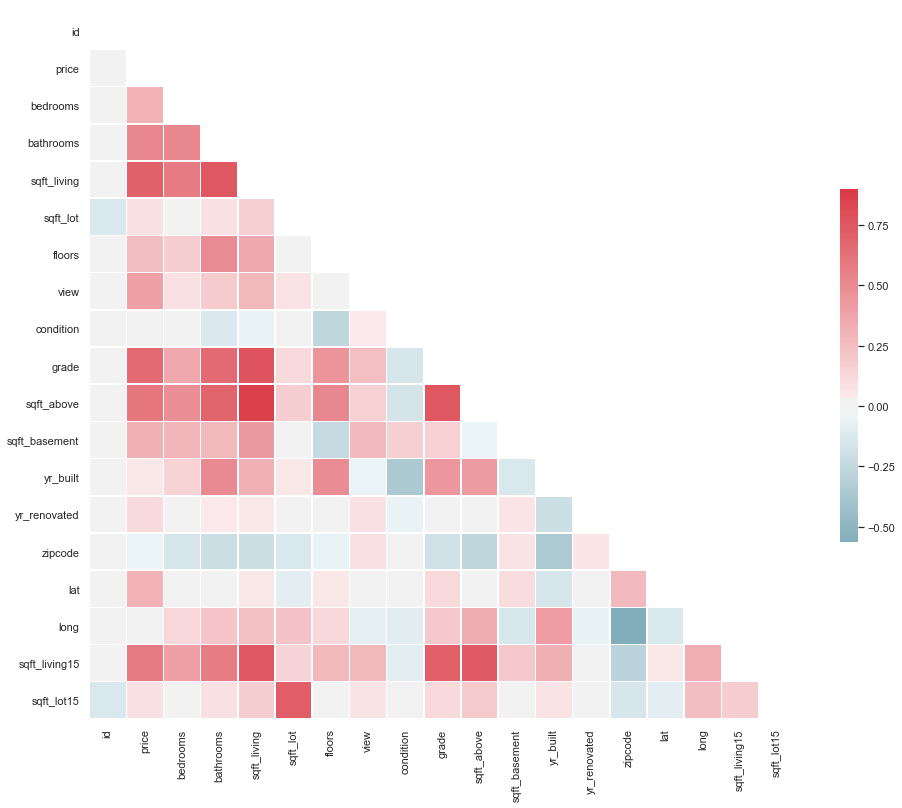

In [31]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = df.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16,13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220,10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [32]:
(abs(df.corr()) > 0.76).sum()

id               1
price            1
bedrooms         1
bathrooms        1
sqft_living      3
sqft_lot         1
floors           1
view             1
condition        1
grade            2
sqft_above       2
sqft_basement    1
yr_built         1
yr_renovated     1
zipcode          1
lat              1
long             1
sqft_living15    1
sqft_lot15       1
dtype: int64

In [33]:
(abs(df.corr()) > 0.76)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False


sqft_living
-grade
-sqft_above

All have multicollinearity above .76 (absolute value)

the column sqft_living is highly correlated with both grade and sqft_above.  Given that sqft_above seems like it's capturing similiar info, I think we should remove sqft_living.  I especially didn't want to get rid of grade because I'm interested to include that in the model

In [34]:
df = df.drop('sqft_living', axis=1)

In [35]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,5650,1.0,nan,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# One-Hot
only column to transform is waterfront
but date is also an object and will be treated like a category, not what we want

So I will change the type of the date column from string to a datetime type.  Hopefully that way the get_dummies() method will ignore that column

In [36]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format = True)

In [37]:
df = pd.get_dummies(df)

# Analyze Distributions

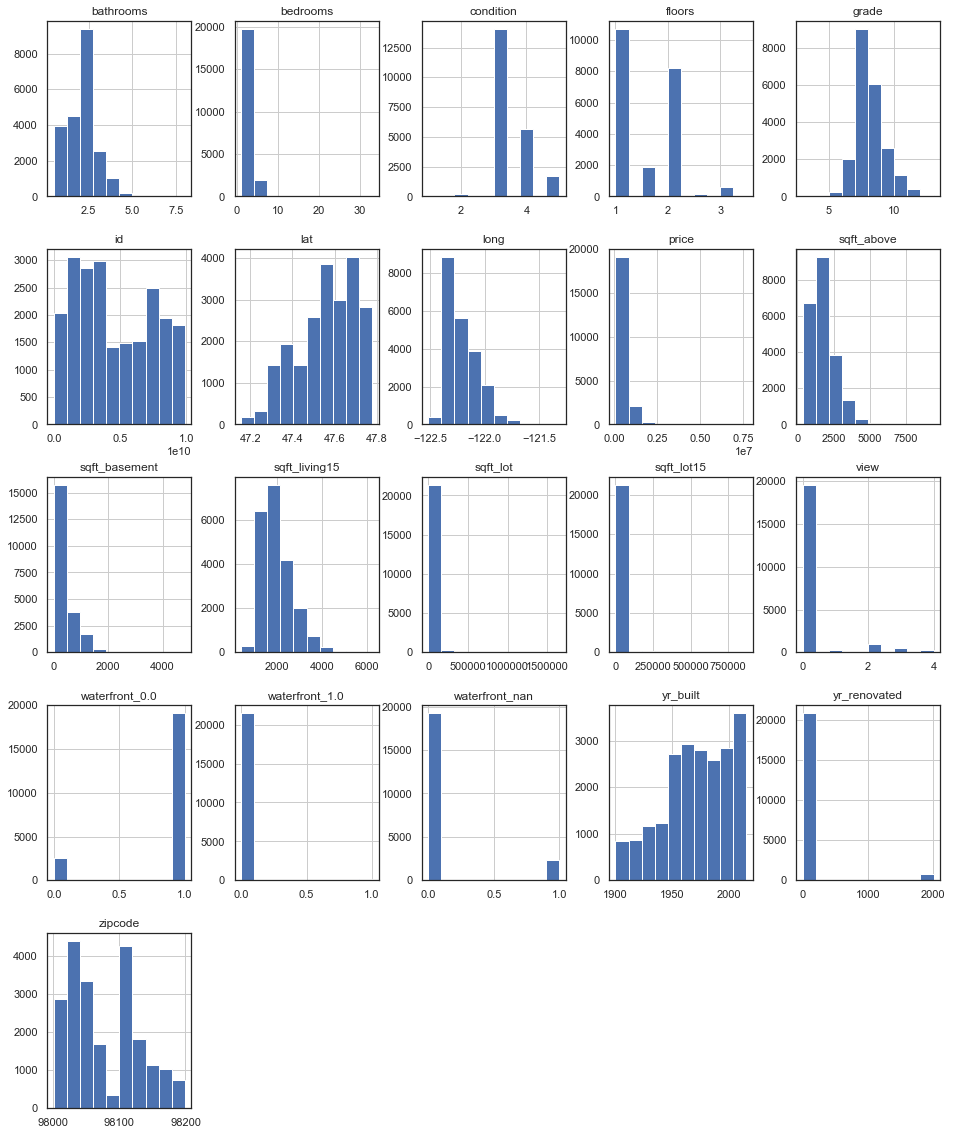

In [38]:
df.hist(figsize=(16,20));

# Closely examine each variable

let's go through each variable individually to really get a sense of things like skew, symmetry, kurtosis, etc.

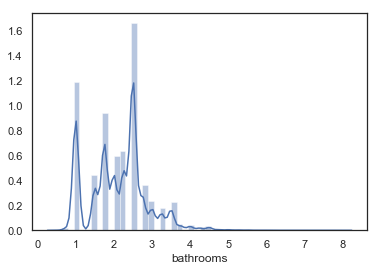

In [39]:
sns.distplot(df.bathrooms)

In [40]:
df.bathrooms.value_counts()

2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

it seems kinda strange there are so many houses with just one bathroom.  must be a lot of small and/or old houses in king's county

EDA Question-
Why are there so many houses with just 1 bathroom in this dataset?

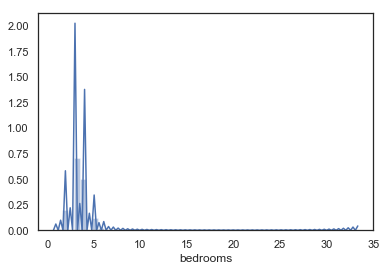

In [41]:
sns.distplot(df.bedrooms)

In [42]:
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

1 house having 33 bedrooms is an insane outlier.  that must be some sort of mistake, maybe that place was less a house and more of some sort of public building

EDA Question- 
Is there something special about the house with 33 bathrooms? What does the other data of the columns in that row tell us about this outlier

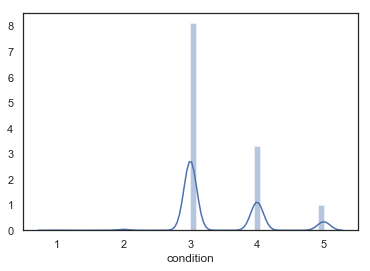

In [43]:
sns.distplot(df.condition)

In [44]:
df.condition.value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

the negative tail is extremely shallow

EDA Question-
Who came up with this condition variable? Who is making the determination of what condition a house is in? What are the criteria they use? Any information we could get about this variable from the customer would be helpful in understanding it

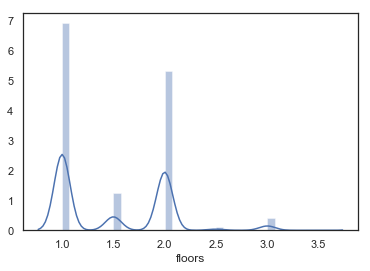

In [45]:
sns.distplot(df.floors)

not very normal.  very positively skewed and with a second peak at 2

In [46]:
df.floors.describe()

count    21597.000000
mean         1.494096
std          0.539683
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

Edit- The mean andn median are basically the same so technically the distribution is not skewed but it certainly looks like it.  One thing for certain is the mode (of 1) is smaller than the mean and median so this is not a normal distribution

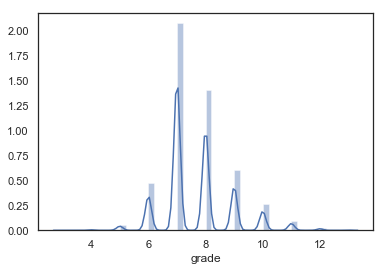

In [47]:
sns.distplot(df.grade)

the positive tail is much thicker than the negative tail.  making the distribution less symmetrical

EDA Question?
Similar to the condition variable, who and what determines a grade value?  More info from customer should be asked

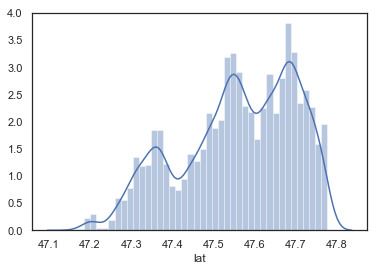

In [48]:
sns.distplot(df.lat)

slight negative skew (or at least a tail in the negative direction), sharp cutoff after peak to the positive side

In [49]:
df.lat.describe()

count    21597.000000
mean        47.560093
std          0.138552
min         47.155900
25%         47.471100
50%         47.571800
75%         47.678000
max         47.777600
Name: lat, dtype: float64

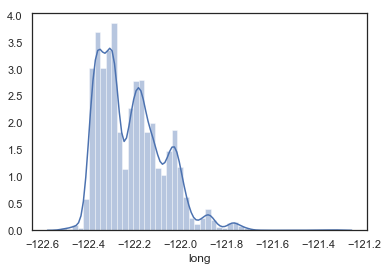

In [50]:
sns.distplot(df.long)

normality is pretty good.  just some positive skew.  edit-actually not great. still passable though

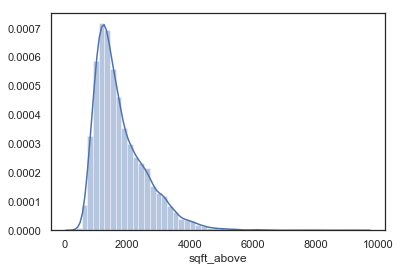

In [51]:
sns.distplot(df.sqft_above)

normality looks pretty good.  just some positive skew

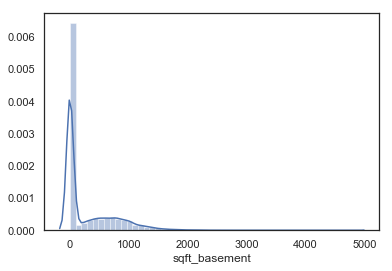

In [52]:
sns.distplot(df.sqft_basement)

normality is not great.  but it's because of the data, the 0s and 1s are just telling us either houses don't have basements or we don't know for some reason.  for the basement data that does exist, it seems normally distributed

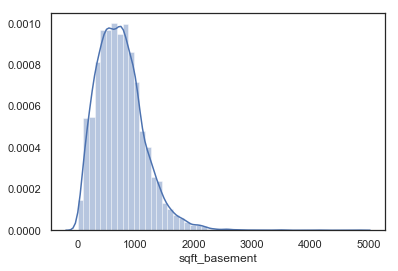

In [53]:
sns.distplot(df.loc[df.sqft_basement > 2, 'sqft_basement'])

this shows how the actual basement square footage data that exists is actually strikingly similar in distribution to the sqft_above variable

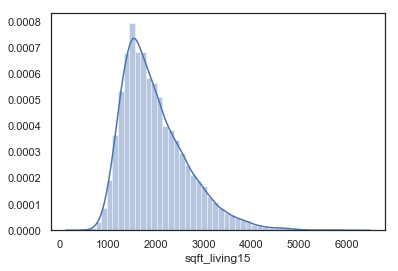

In [54]:
sns.distplot(df.sqft_living15)

sqft_living15- pretty good, positive skew

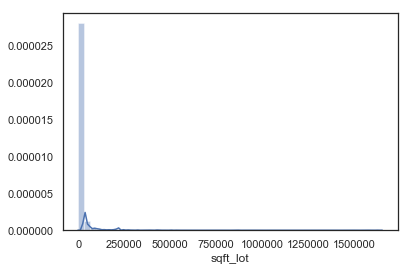

In [55]:
sns.distplot(df.sqft_lot)

In [56]:
df.sqft_lot.describe()

count    2.159700e+04
mean     1.509941e+04
std      4.141264e+04
min      5.200000e+02
25%      5.040000e+03
50%      7.618000e+03
75%      1.068500e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

In [57]:
df.loc[df.sqft_lot > 800000, 'sqft_lot'].value_counts()

871200     2
1651359    1
843309     1
920423     1
1074218    1
1164794    1
982278     1
982998     1
881654     1
1024068    1
Name: sqft_lot, dtype: int64

there are a few crazy outliers causing the extreme skew

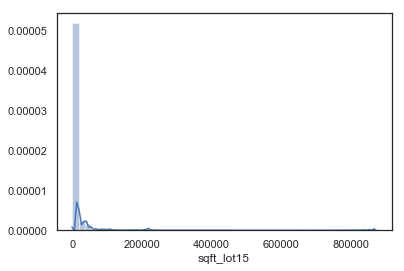

In [58]:
sns.distplot(df.sqft_lot15)

In [59]:
df.sqft_lot15.describe()

count     21597.000000
mean      12758.283512
std       27274.441950
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10083.000000
max      871200.000000
Name: sqft_lot15, dtype: float64

sqft_lot15; extreme skew again

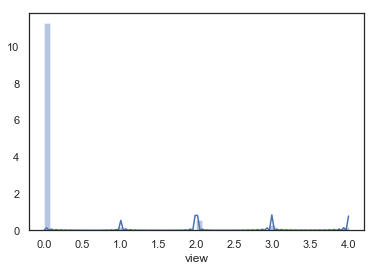

In [60]:
sns.distplot(df.view)

view- not good.  positive skew

EDA Question-
What do these values really represent?  We should go to the customer for help

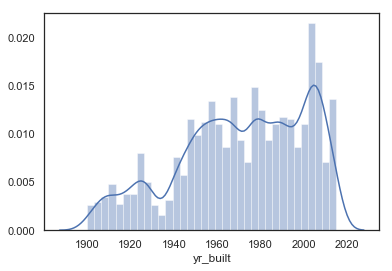

In [61]:
sns.distplot(df.yr_built)

yr_built- not terrible. negative skew

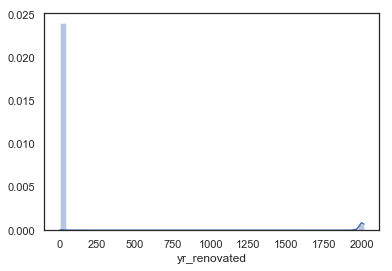

In [62]:
sns.distplot(df.yr_renovated)

In [63]:
df.yr_renovated.value_counts().head(10)

0.0       20853
2014.0       73
2003.0       31
2013.0       31
2007.0       30
2000.0       29
2005.0       29
1990.0       22
2004.0       22
2009.0       21
Name: yr_renovated, dtype: int64

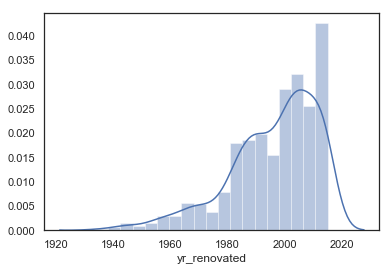

In [64]:
sns.distplot(df.loc[df.yr_renovated > 1, 'yr_renovated'])
#distribution of the truly valid/applicable data

yr_renovated- not good, crazy skew.  this really isn't a continuous variable with almost all values being 0 (null)

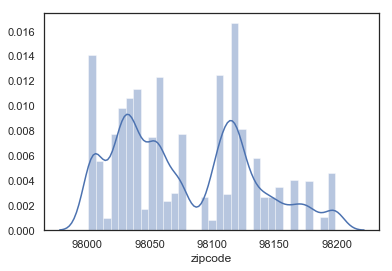

In [65]:
sns.distplot(df.zipcode)

zipcode- not good

# Linearity Checks

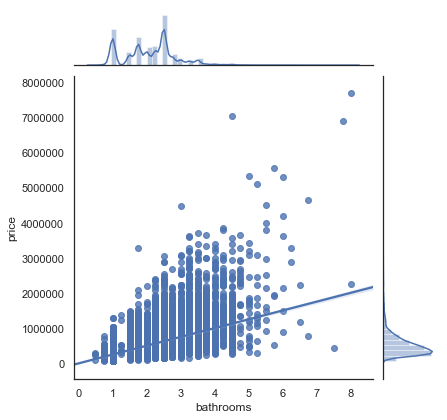

In [66]:
sns.jointplot(x='bathrooms', y='price', data=df, kind='reg')

looks okay

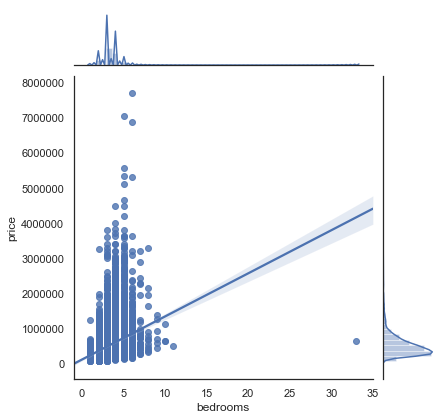

In [67]:
sns.jointplot(x='bedrooms', y='price', data=df, kind='reg')

even without the crazy outlier, doesn't look to be very linear, not awful though but I thought it would be moreso.  it actually looks more parabolic than linear

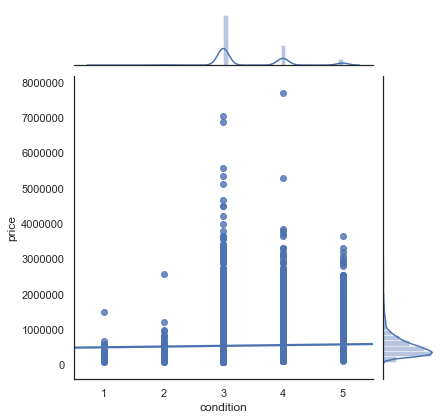

In [68]:
sns.jointplot(x='condition', y='price', data=df, kind='reg')

not continuous, shouldn't have made this plot. does still appear to be slightly positive linear relationship

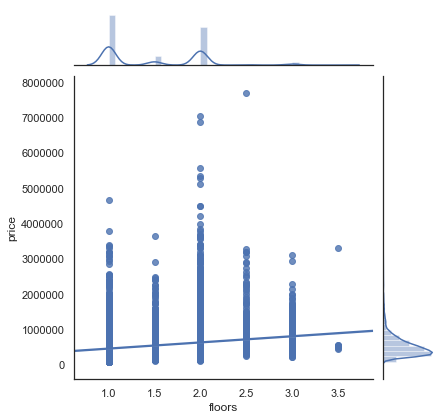

In [69]:
sns.jointplot(x='floors', y='price', data=df, kind='reg')

not great, passable though I think

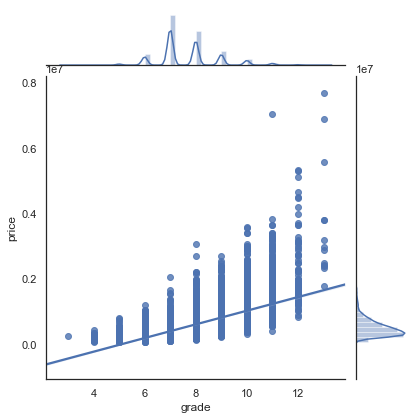

In [70]:
sns.jointplot(x='grade', y='price', data=df, kind='reg')

looks okay

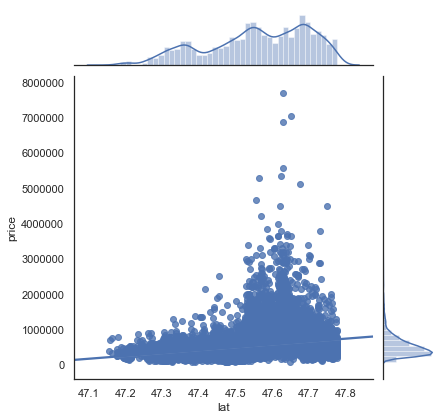

In [71]:
sns.jointplot(x='lat', y='price', data=df, kind='reg')

passable

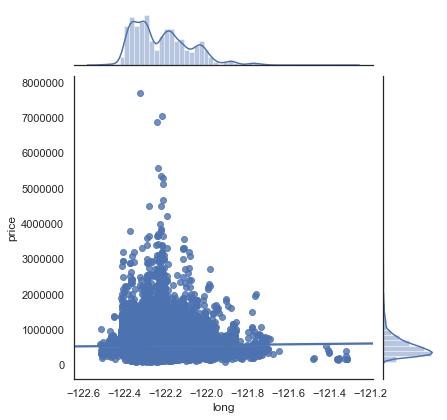

In [72]:
sns.jointplot(x='long', y='price', data=df, kind='reg')

idk. if there is any relationship it's not a linear one

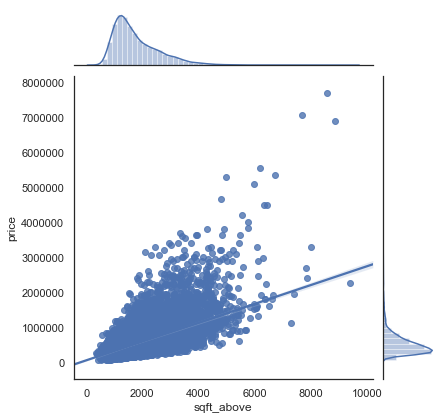

In [73]:
sns.jointplot(x='sqft_above', y='price', data=df, kind='reg')

looks good

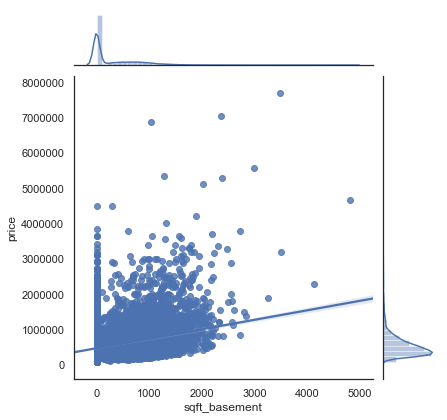

In [74]:
sns.jointplot(x='sqft_basement', y='price', data=df, kind='reg')

passable

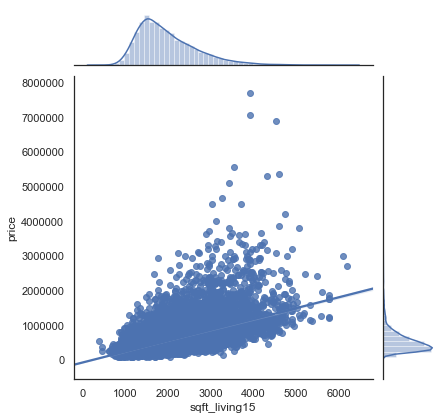

In [75]:
sns.jointplot(x='sqft_living15', y='price', data=df, kind='reg')

looks good

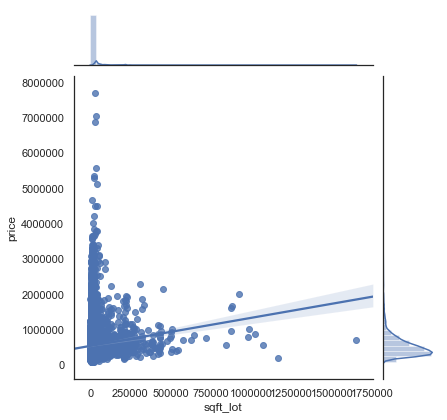

In [76]:
sns.jointplot(x='sqft_lot', y='price', data=df, kind='reg')

idk

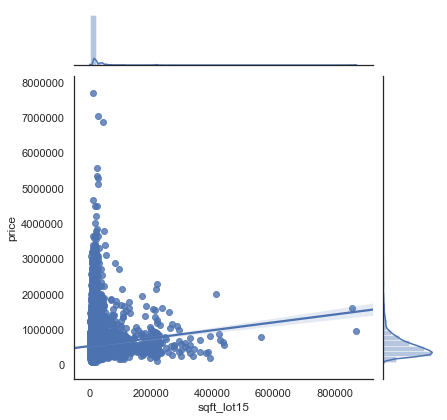

In [77]:
sns.jointplot(x='sqft_lot15', y='price', data=df, kind='reg')

idk

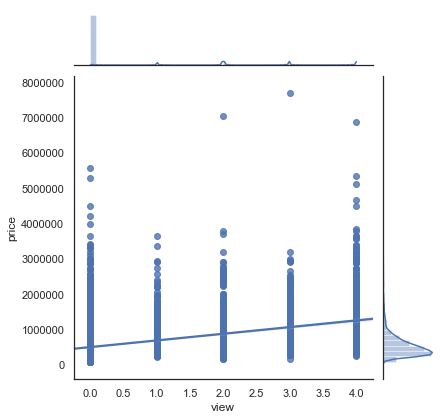

In [78]:
sns.jointplot(x='view', y='price', data=df, kind='reg')

not really continuous

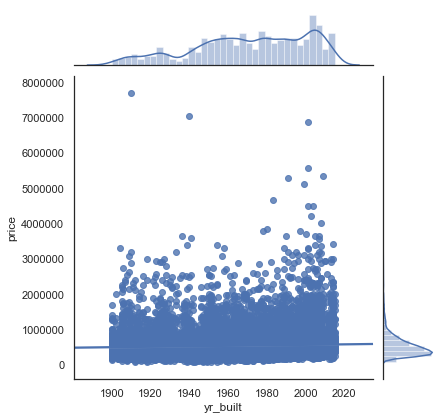

In [79]:
sns.jointplot(x='yr_built', y='price', data=df, kind='reg')

passable I think

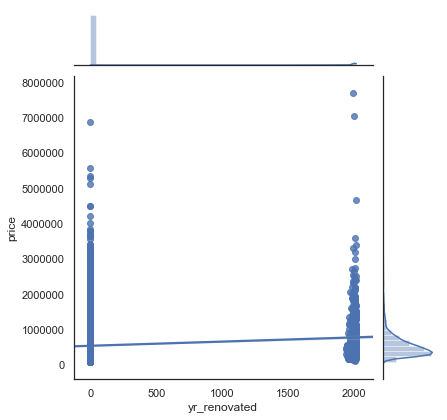

In [80]:
sns.jointplot(x='yr_renovated', y='price', data=df, kind='reg')

unreadable with the data as is

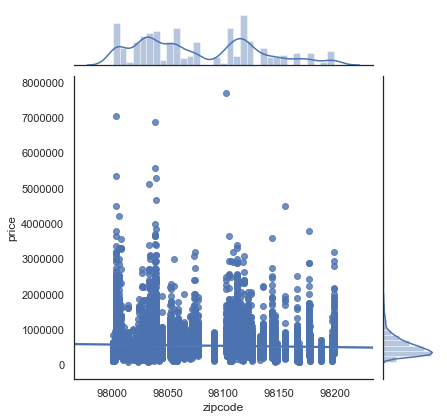

In [81]:
sns.jointplot(x='zipcode', y='price', data=df, kind='reg')

doesn't seem linear

# Drop or Change any columns?

Let's now recheck whether some variables should be altered or thrown out because they don't pass the assumptions needed to be fit to be included in our modeling later on

bathrooms- YES
    normality- ok
    linearity- ok
bedrooms- NO
    normality- not okay
    linearity- not okay
condition- YES
    normality- ok
    linearity- ok
floors- BARELY Yes
    normality- ok
    linearity- ok
grade- YES
    normality- ok
    linearity- ok
lat- slight Yes
    normality- ok
    linearity- ok
long- no
    normality- not great
    linearity- none
sqft_above- Yes
    normality- ok
    linearity- ok
*sqft_basement- 
    normality- ok
    linearity- ok
sqft_living15- Yep
    normality- ok
    linearity- ok
sqft_lot- take it or leave it
    normality- bad skew because of outliers
    linearity- not good
sqft_lot15- if you take this one, don't take previous
    normality- bad skew
    linearity- maybe passable
view- keep
    normality- not good
    linearity- ok
yr_built- No
    normality- maybe passable 
    linearity- no 
*yr_renovated- 
    normality- ok
    linearity- ok
zip- no
    normality- not good
    linearity- not good

*columns need to be changed

yr_renovated needs be changed because over 20,000 of it's values are 0.  

that leaves the few actual years that are recorded practically useless because all plots and descriptive analysis are ruined by the skewness of all the 0 values.  To still be able to get some information out of this column, I think we should change this to a dummy variable basically saying whether the house has been renovated or not.  so we'll leave all the 0 values as 0 as they represent not rennovated and then we'll change all the non-zero values to 1 to represent renovated.  then we'll use the get_dummies() method

In [82]:
df.loc[df.yr_renovated > 0.0, 'yr_renovated'] = 1.0

In [83]:
df.yr_renovated.value_counts()

0.0    20853
1.0      744
Name: yr_renovated, dtype: int64

In [84]:
df.yr_renovated = df.yr_renovated.astype('str')

In [85]:
df = pd.get_dummies(df)

Now time to change sqft_basement

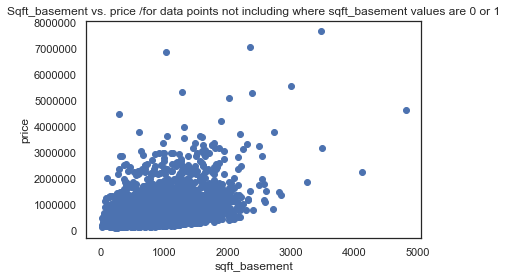

In [86]:
plt.scatter(df.loc[df.sqft_basement > 1, 'sqft_basement'], df.loc[df.sqft_basement > 1, 'price'])
plt.title('Sqft_basement vs. price /for data points not including where sqft_basement values are 0 or 1')
plt.xlabel('sqft_basement')
plt.ylabel('price')
plt.show()

for the none 0 or 1 values (houses with specified basement square footage values), there does seem to be a slightly positive linear relationship

I think we should do the same thing we just did with yr_renovated to sqft_basement.  1/2 the values are 0 which would skew the data too much to be useful as a continuous variable.  We can just change the variable to either has a basement or doesn't have a basement and see if that affects price.  but first we need to change the manufactured 1 values to 0s because they will go into the 'no basement' category too.  then we will change all values > 0 to 1 and then change to type string and then to a dummy variable format

In [87]:
df.sqft_basement.value_counts().head()

0.0      12826
1.0        454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

In [88]:
df.loc[df.sqft_basement == 1.0, 'sqft_basement'] = 0.0

In [89]:
df.loc[df.sqft_basement > 1.0, 'sqft_basement'] = 1.0

In [90]:
df.sqft_basement.value_counts()

0.0    13280
1.0     8317
Name: sqft_basement, dtype: int64

In [91]:
df.sqft_basement = df.sqft_basement.astype('str')

In [92]:
df = pd.get_dummies(df)

In [93]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_lot,floors,view,condition,grade,...,long,sqft_living15,sqft_lot15,waterfront_0.0,waterfront_1.0,waterfront_nan,yr_renovated_0.0,yr_renovated_1.0,sqft_basement_0.0,sqft_basement_1.0
0,7129300520,2014-10-13,221900.0,3,1.00,5650,1.0,0.0,3,7,...,-122.257,1340,5650,0,0,1,1,0,1,0
1,6414100192,2014-12-09,538000.0,3,2.25,7242,2.0,0.0,3,7,...,-122.319,1690,7639,1,0,0,0,1,0,1
2,5631500400,2015-02-25,180000.0,2,1.00,10000,1.0,0.0,3,6,...,-122.233,2720,8062,1,0,0,1,0,1,0
3,2487200875,2014-12-09,604000.0,4,3.00,5000,1.0,0.0,5,7,...,-122.393,1360,5000,1,0,0,1,0,0,1
4,1954400510,2015-02-18,510000.0,3,2.00,8080,1.0,0.0,3,8,...,-122.045,1800,7503,1,0,0,1,0,1,0


# Drop Columns
okay, time to remove the variables that fail the normality assumptions too badly:
bedrooms, long, yr_built, zipcode

In [94]:
df = df.drop(['bedrooms', 'long', 'yr_built', 'zipcode'], axis=1)

In [95]:
df.head()

,id,date,price,bathrooms,sqft_lot,floors,view,condition,grade,sqft_above,lat,sqft_living15,sqft_lot15,waterfront_0.0,waterfront_1.0,waterfront_nan,yr_renovated_0.0,yr_renovated_1.0,sqft_basement_0.0,sqft_basement_1.0
0,7129300520,2014-10-13,221900.0,1.00,5650,1.0,0.0,3,7,1180,47.5112,1340,5650,0,0,1,1,0,1,0
1,6414100192,2014-12-09,538000.0,2.25,7242,2.0,0.0,3,7,2170,47.7210,1690,7639,1,0,0,0,1,0,1
2,5631500400,2015-02-25,180000.0,1.00,10000,1.0,0.0,3,6,770,47.7379,2720,8062,1,0,0,1,0,1,0
3,2487200875,2014-12-09,604000.0,3.00,5000,1.0,0.0,5,7,1050,47.5208,1360,5000,1,0,0,1,0,0,1
4,1954400510,2015-02-18,510000.0,2.00,8080,1.0,0.0,3,8,1680,47.6168,1800,7503,1,0,0,1,0,1,0


In [96]:
predictors = df.loc[:, df.drop(['id', 'date', 'price'], axis=1).columns]
#making a separate df for just the predictor variables.  id and date are just informative variables, I don't think they
#were meant to be analyzed like the others.  and then the price variable is our target variable

# Modeling

Initial model

In [97]:
import statsmodels.api as sm
predictors_int = sm.add_constant(predictors)
model = sm.OLS(df.price,predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     2982.
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        06:24:04   Log-Likelihood:            -2.9577e+05
No. Observations:               21597   AIC:                         5.916e+05
Df Residuals:                   21582   BIC:                         5.917e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -1.39e+07   2.21e+05    -62.987      0.000   -1.43e+07   -1.35e+07
bathrooms          8702.7874   3116.859      2.792      0.005    2593.514    1.48e+04
sqft_lot              0.1546      0.051      3.037      0.002       0.055       0.254
floors            -3.779e+04   3614.206    -10.456      0.000   -4.49e+04   -3.07e+04
view               7.347e+04   2195.224     33.469      0.000    6.92e+04    7.78e+04
condition          6.338e+04   2343.748     27.042      0.000    5.88e+04     6.8e+04
grade              9.223e+04   2211.497     41.703      0.000    8.79e+04    9.66e+04
sqft_above          169.4622      3.748     45.215      0.000     162.116     176.808
lat                 6.73e+05   1.09e+04     62.013      0.000    6.52e+05    6.94e+05
sqft_living15        22.7868      3.544      6.429      0.000      15.840      29.734
sqft_lot15           -0.5079      0.078     -6.535      0.000      -0.660      -0.356
waterfront_0.0    -4.842e+06   7.38e+04    -65.595      0.000   -4.99e+06    -4.7e+06
waterfront_1.0    -4.207e+06   7.47e+04    -56.333      0.000   -4.35e+06   -4.06e+06
waterfront_nan    -4.847e+06   7.39e+04    -65.600      0.000   -4.99e+06    -4.7e+06
yr_renovated_0.0  -7.022e+06    1.1e+05    -63.696      0.000   -7.24e+06   -6.81e+06
yr_renovated_1.0  -6.874e+06   1.11e+05    -62.196      0.000   -7.09e+06   -6.66e+06
sqft_basement_0.0     -7e+06    1.1e+05    -63.591      0.000   -7.22e+06   -6.78e+06
sqft_basement_1.0 -6.896e+06   1.11e+05    -62.367      0.000   -7.11e+06   -6.68e+06
==============================================================================
Omnibus:                    19562.433   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2230114.436
Skew:                           3.930   Prob(JB):                         0.00
Kurtosis:                      52.158   Cond. No.                     4.85e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.34e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Seems like a pretty good initial model with an adj R2 of .659.  But the skew is high at 3.93, the kurtosis is high at 52 and the JB is over 2 million!  So there is definitely improvement to be made

I have not scaled or normalized the data yet.  It probably should be done

# Z-score Standardization

I have learned something.  It's good to keep a copy of the original data so I can access it should something go wrong down the line.  I found myself having to reload all the data again because of the null values that resulted in logging a negative number.  

So I will leave the raw untouched data in the df dataframe.  And make a predictors dataframe and a target dataframe that I will make whatever necessary changes that are called for at that time

In [98]:
predictors.bathrooms = (predictors.bathrooms - predictors.bathrooms.mean()) / predictors.bathrooms.std()
predictors.sqft_lot = (predictors.sqft_lot - predictors.sqft_lot.mean()) / predictors.sqft_lot.std()
predictors.floors = (predictors.floors - predictors.floors.mean()) / predictors.floors.std()
predictors.view = (predictors.view - predictors.view.mean()) / predictors.view.std()
predictors.condition = (predictors.condition - predictors.condition.mean()) / predictors.condition.std()
predictors.grade = (predictors.grade - predictors.grade.mean()) / predictors.grade.std()
predictors.sqft_above = (predictors.sqft_above - predictors.sqft_above.mean()) / predictors.sqft_above.std()
predictors.lat = (predictors.lat - predictors.lat.mean()) / predictors.lat.std()
predictors.sqft_living15 = (predictors.sqft_living15 - predictors.sqft_living15.mean()) / predictors.sqft_living15.std()
predictors.sqft_lot15 = (predictors.sqft_lot15 - predictors.sqft_lot15.mean()) / predictors.sqft_lot15.std()

In [99]:
target = pd.DataFrame(df.price)

In [100]:
target.price = (target.price - target.price.mean()) / target.price.std()

In [101]:
predictors.head()

,bathrooms,sqft_lot,floors,view,condition,grade,sqft_above,lat,sqft_living15,sqft_lot15,waterfront_0.0,waterfront_1.0,waterfront_nan,yr_renovated_0.0,yr_renovated_1.0,sqft_basement_0.0,sqft_basement_1.0
0,-1.451039,-0.228177,-0.915531,-0.304942,-0.629972,-0.560787,-0.735234,-0.352886,-0.943654,-0.260621,0,0,1,1,0,1,0
1,0.174482,-0.189735,0.937409,-0.304942,-0.629972,-0.560787,0.460766,1.161349,-0.432877,-0.187695,1,0,0,0,1,0,1
2,-1.451039,-0.123137,-0.915531,-0.304942,-0.629972,-1.413157,-1.230546,1.283325,1.070267,-0.172186,1,0,0,1,0,1,0
3,1.149794,-0.243873,-0.915531,-0.304942,2.444371,-0.560787,-0.892284,-0.283598,-0.914467,-0.284453,1,0,0,1,0,0,1
4,-0.150622,-0.169499,-0.915531,-0.304942,-0.629972,0.291583,-0.131194,0.409284,-0.272347,-0.192682,1,0,0,1,0,1,0


Okay, let's run the regression test again now that the data has been standardized

In [102]:
import statsmodels.api as sm
predictors_int = sm.add_constant(predictors)
model = sm.OLS(target,predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     2982.
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        06:24:04   Log-Likelihood:                -19019.
No. Observations:               21597   AIC:                         3.807e+04
Df Residuals:                   21582   BIC:                         3.819e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3351      0.009     38.472      0.000       0.318       0.352
bathrooms             0.0182      0.007      2.792      0.005       0.005       0.031
sqft_lot              0.0174      0.006      3.037      0.002       0.006       0.029
floors               -0.0555      0.005    -10.456      0.000      -0.066      -0.045
view                  0.1529      0.005     33.469      0.000       0.144       0.162
condition             0.1122      0.004     27.042      0.000       0.104       0.120
grade                 0.2945      0.007     41.703      0.000       0.281       0.308
sqft_above            0.3818      0.008     45.215      0.000       0.365       0.398
lat                   0.2538      0.004     62.013      0.000       0.246       0.262
sqft_living15         0.0425      0.007      6.429      0.000       0.030       0.055
sqft_lot15           -0.0377      0.006     -6.535      0.000      -0.049      -0.026
waterfront_0.0       -0.4610      0.016    -29.122      0.000      -0.492      -0.430
waterfront_1.0        1.2694      0.038     33.802      0.000       1.196       1.343
waterfront_nan       -0.4733      0.017    -27.290      0.000      -0.507      -0.439
yr_renovated_0.0     -0.0333      0.010     -3.409      0.001      -0.052      -0.014
yr_renovated_1.0      0.3684      0.014     27.109      0.000       0.342       0.395
sqft_basement_0.0     0.0263      0.007      4.008      0.000       0.013       0.039
sqft_basement_1.0     0.3088      0.007     44.654      0.000       0.295       0.322
==============================================================================
Omnibus:                    19562.433   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2230114.436
Skew:                           3.930   Prob(JB):                         0.00
Kurtosis:                      52.158   Cond. No.                     5.84e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.27e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The major statistics did not change!

# Recursive Feature Selection

let's use recursive feature selection to find out the better fitting predictors

In [103]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 3)
selector = selector.fit(predictors, target)

In [104]:
from itertools import compress

In [105]:
winners = list(compress(predictors.columns, selector.support_))
winners

['waterfront_0.0', 'waterfront_1.0', 'waterfront_nan']

RFE thinks these (above) are the best two predictors

In [106]:

r_squared = []
adj_r_sq = []


linreg = LinearRegression()
for n in range(5,len(predictors.columns),2):
    selectors = RFE(linreg, n_features_to_select = n)
    selectors = selectors.fit(predictors, target)
    winners = list(compress(predictors.columns, selectors.support_))
    print(winners)
    
    with_intercept = sm.add_constant(predictors[winners])
    model = sm.OLS(target, with_intercept).fit()
    
    linreg2 = LinearRegression()
    linreg2.fit(predictors[winners], target)
    y_hat = linreg2.predict(predictors[winners])
    mse = np.sum((target - y_hat)**2)/len(target)
    
    print(model.rsquared)
    print(model.rsquared_adj)
    print(mse)
    
#loop to examine how the model performs when adding more variables to the regression equation. starting at 5 predictors
#and adding 2 each time until all the predictors are included

['grade', 'waterfront_0.0', 'waterfront_1.0', 'waterfront_nan', 'yr_renovated_1.0']
0.49864542789390753
0.4985525500554291
price    0.501331
dtype: float64
['grade', 'sqft_above', 'waterfront_0.0', 'waterfront_1.0', 'waterfront_nan', 'yr_renovated_1.0', 'sqft_basement_1.0']
0.562963469535271
0.5628420142697412
price    0.437016
dtype: float64
['grade', 'sqft_above', 'lat', 'waterfront_0.0', 'waterfront_1.0', 'waterfront_nan', 'yr_renovated_1.0', 'sqft_basement_0.0', 'sqft_basement_1.0']
0.6203672463685627
0.6202441545497929
price    0.379615
dtype: float64
['view', 'grade', 'sqft_above', 'lat', 'waterfront_0.0', 'waterfront_1.0', 'waterfront_nan', 'yr_renovated_0.0', 'yr_renovated_1.0', 'sqft_basement_0.0', 'sqft_basement_1.0']
0.642135935548352
0.6420033196267468
price    0.357847
dtype: float64
['floors', 'view', 'condition', 'grade', 'sqft_above', 'lat', 'waterfront_0.0', 'waterfront_1.0', 'waterfront_nan', 'yr_renovated_0.0', 'yr_renovated_1.0', 'sqft_basement_0.0', 'sqft_basement_

The model improved sharply when adding the next 2 best features the first couple times.  But the additional improvement to the R2 and adj R2 flattened out quickly.  For examples, adding the last 2 best features made practically no improvement to the model.

But before we get too deep into exactly how many features to include in our final model, let's try to improve our model in general first.

Maybe we can readjust our data to help.  Maybe log'ing the data can help with our skewness problems

# Tweaking the data

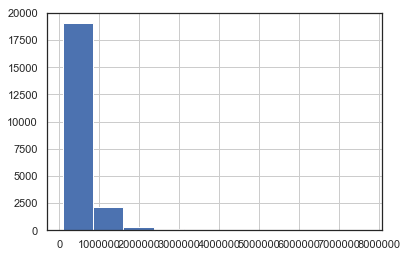

In [107]:
df.price.hist()

In [108]:
df.price.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

the target is very skewed, lets definitely take the log of that to see if that helps

I can't take the log of negative numbers so I must change the price column back to it's original form before doing a log transformation

In [109]:
target.price = df.price

In [110]:
target.price = np.log(target.price)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023D73252240>]],
      dtype=object)

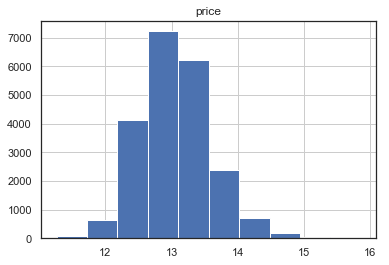

In [111]:
target.hist()

Wow, huge improvement to skew

now let's run the ols to see the impact just that had

In [112]:
predictors_int = sm.add_constant(predictors)
model = sm.OLS(target,predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     4652.
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        06:24:08   Log-Likelihood:                -1773.6
No. Observations:               21597   AIC:                             3577.
Df Residuals:                   21582   BIC:                             3697.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.6935      0.004   1452.698      0.000       5.686       5.701
bathrooms             0.0164      0.003      5.585      0.000       0.011       0.022
sqft_lot              0.0208      0.003      8.067      0.000       0.016       0.026
floors                0.0148      0.002      6.207      0.000       0.010       0.020
view                  0.0611      0.002     29.697      0.000       0.057       0.065
condition             0.0705      0.002     37.763      0.000       0.067       0.074
grade                 0.1662      0.003     52.302      0.000       0.160       0.172
sqft_above            0.1354      0.004     35.633      0.000       0.128       0.143
lat                   0.2035      0.002    110.494      0.000       0.200       0.207
sqft_living15         0.0674      0.003     22.658      0.000       0.062       0.073
sqft_lot15           -0.0112      0.003     -4.303      0.000      -0.016      -0.006
waterfront_0.0        1.7714      0.007    248.667      0.000       1.757       1.785
waterfront_1.0        2.1564      0.017    127.607      0.000       2.123       2.190
waterfront_nan        1.7657      0.008    226.254      0.000       1.750       1.781
yr_renovated_0.0      2.7459      0.004    624.406      0.000       2.737       2.755
yr_renovated_1.0      2.9475      0.006    482.022      0.000       2.936       2.960
sqft_basement_0.0     2.7672      0.003    937.948      0.000       2.761       2.773
sqft_basement_1.0     2.9263      0.003    940.380      0.000       2.920       2.932
==============================================================================
Omnibus:                      392.557   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              619.892
Skew:                           0.183   Prob(JB):                    2.47e-135
Kurtosis:                       3.744   Cond. No.                     5.84e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.27e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

wow, major improvement.  now let's revisit all the predictors that had bad skew and do a log on them

after going back in the notebook to check the plots for each column during EDA, grade and sqft_living15 are the only ones that don't have skew problems.  So lets log all the other features and see if that improves the fit 

In [113]:
log_predictors = df.loc[:, predictors.columns]
#let's make a separate df for the logged data so we can keep our regular predictors dataframe intact

In [114]:
log_predictors.bathrooms = np.log(log_predictors.bathrooms)
log_predictors.floors = np.log(log_predictors.floors)
log_predictors.view = np.log(log_predictors.view)
log_predictors.condition = np.log(log_predictors.condition)
log_predictors.sqft_above = np.log(log_predictors.sqft_above)
log_predictors.lat = np.log(log_predictors.lat)
log_predictors.sqft_lot = np.log(log_predictors.sqft_lot)
log_predictors.sqft_lot15 = np.log(log_predictors.sqft_lot15)

In [115]:
log_predictors.head()

,bathrooms,sqft_lot,floors,view,condition,grade,sqft_above,lat,sqft_living15,sqft_lot15,waterfront_0.0,waterfront_1.0,waterfront_nan,yr_renovated_0.0,yr_renovated_1.0,sqft_basement_0.0,sqft_basement_1.0
0,0.000000,8.639411,0.000000,-inf,1.098612,7,7.073270,3.860965,1340,8.639411,0,0,1,1,0,1,0
1,0.810930,8.887653,0.693147,-inf,1.098612,7,7.682482,3.865372,1690,8.941022,1,0,0,0,1,0,1
2,0.000000,9.210340,0.000000,-inf,1.098612,6,6.646391,3.865726,2720,8.994917,1,0,0,1,0,1,0
3,1.098612,8.517193,0.000000,-inf,1.609438,7,6.956545,3.861168,1360,8.517193,1,0,0,1,0,0,1
4,0.693147,8.997147,0.000000,-inf,1.098612,8,7.426549,3.863186,1800,8.923058,1,0,0,1,0,1,0


In [116]:
(log_predictors.view == -np.inf).sum()

19485

In [117]:
(log_predictors.sqft_lot15 == -np.inf).sum()

0

none of the columns besides view have -inf values so it was the only row with "0" values that messed up the log process.  I'll just change the view column back to the unlogged data

In [118]:
log_predictors.view = df.view

In [119]:
log_predictors.head()

,bathrooms,sqft_lot,floors,view,condition,grade,sqft_above,lat,sqft_living15,sqft_lot15,waterfront_0.0,waterfront_1.0,waterfront_nan,yr_renovated_0.0,yr_renovated_1.0,sqft_basement_0.0,sqft_basement_1.0
0,0.000000,8.639411,0.000000,0.0,1.098612,7,7.073270,3.860965,1340,8.639411,0,0,1,1,0,1,0
1,0.810930,8.887653,0.693147,0.0,1.098612,7,7.682482,3.865372,1690,8.941022,1,0,0,0,1,0,1
2,0.000000,9.210340,0.000000,0.0,1.098612,6,6.646391,3.865726,2720,8.994917,1,0,0,1,0,1,0
3,1.098612,8.517193,0.000000,0.0,1.609438,7,6.956545,3.861168,1360,8.517193,1,0,0,1,0,0,1
4,0.693147,8.997147,0.000000,0.0,1.098612,8,7.426549,3.863186,1800,8.923058,1,0,0,1,0,1,0


In [120]:
log_predictors_int = sm.add_constant(log_predictors)
model = sm.OLS(target,log_predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     4640.
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        06:24:09   Log-Likelihood:                -1796.2
No. Observations:               21597   AIC:                             3622.
Df Residuals:                   21582   BIC:                             3742.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -111.0918      1.058   -104.967      0.000    -113.166    -109.017
bathrooms            -0.0062      0.007     -0.840      0.401      -0.021       0.008
sqft_lot              0.0408      0.005      7.853      0.000       0.031       0.051
floors                0.0207      0.008      2.682      0.007       0.006       0.036
view                  0.0803      0.003     29.850      0.000       0.075       0.086
condition             0.3746      0.010     36.374      0.000       0.354       0.395
grade                 0.1464      0.003     54.910      0.000       0.141       0.152
sqft_above            0.3374      0.009     35.975      0.000       0.319       0.356
lat                  69.5039      0.638    108.862      0.000      68.252      70.755
sqft_living15         0.0001   4.39e-06     26.251      0.000       0.000       0.000
sqft_lot15           -0.0669      0.006    -11.807      0.000      -0.078      -0.056
waterfront_0.0      -37.1684      0.353   -105.329      0.000     -37.860     -36.477
waterfront_1.0      -36.7482      0.353   -104.070      0.000     -37.440     -36.056
waterfront_nan      -37.1751      0.353   -105.338      0.000     -37.867     -36.483
yr_renovated_0.0    -55.6468      0.529   -105.189      0.000     -56.684     -54.610
yr_renovated_1.0    -55.4451      0.529   -104.737      0.000     -56.483     -54.407
sqft_basement_0.0   -55.6275      0.529   -105.167      0.000     -56.664     -54.591
sqft_basement_1.0   -55.4644      0.529   -104.766      0.000     -56.502     -54.427
==============================================================================
Omnibus:                      527.267   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              785.827
Skew:                           0.261   Prob(JB):                    2.29e-171
Kurtosis:                       3.776   Cond. No.                     6.06e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.6e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

largely the same, but bathroom and floors now is giving us troubles where as it didn't before it was logged.  let's unlog bathrooms and check the difference

In [121]:
log_predictors.bathrooms = df.bathrooms

In [122]:
log_predictors_int = sm.add_constant(log_predictors)
model = sm.OLS(target,log_predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     4645.
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        06:24:09   Log-Likelihood:                -1786.9
No. Observations:               21597   AIC:                             3604.
Df Residuals:                   21582   BIC:                             3724.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -111.4615      1.056   -105.506      0.000    -113.532    -109.391
bathrooms             0.0169      0.004      4.381      0.000       0.009       0.024
sqft_lot              0.0415      0.005      8.010      0.000       0.031       0.052
floors                0.0123      0.008      1.595      0.111      -0.003       0.027
view                  0.0804      0.003     29.919      0.000       0.075       0.086
condition             0.3751      0.010     36.438      0.000       0.355       0.395
grade                 0.1443      0.003     53.947      0.000       0.139       0.150
sqft_above            0.3183      0.009     34.060      0.000       0.300       0.337
lat                  69.7556      0.637    109.483      0.000      68.507      71.004
sqft_living15         0.0001   4.39e-06     26.127      0.000       0.000       0.000
sqft_lot15           -0.0666      0.006    -11.757      0.000      -0.078      -0.055
waterfront_0.0      -37.2915      0.352   -105.870      0.000     -37.982     -36.601
waterfront_1.0      -36.8718      0.352   -104.604      0.000     -37.563     -36.181
waterfront_nan      -37.2982      0.352   -105.879      0.000     -37.989     -36.608
yr_renovated_0.0    -55.8309      0.528   -105.727      0.000     -56.866     -54.796
yr_renovated_1.0    -55.6306      0.528   -105.276      0.000     -56.666     -54.595
sqft_basement_0.0   -55.8073      0.528   -105.693      0.000     -56.842     -54.772
sqft_basement_1.0   -55.6542      0.528   -105.318      0.000     -56.690     -54.618
==============================================================================
Omnibus:                      530.634   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              781.148
Skew:                           0.266   Prob(JB):                    2.38e-170
Kurtosis:                       3.765   Cond. No.                     5.78e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.85e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

bathrooms is fine again but floors is actually worse.  let's unlog floors to see if that helps

In [123]:
log_predictors.floors = df.floors

In [124]:
log_predictors_int = sm.add_constant(log_predictors)
model = sm.OLS(target,log_predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     4644.
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        06:24:09   Log-Likelihood:                -1788.1
No. Observations:               21597   AIC:                             3606.
Df Residuals:                   21582   BIC:                             3726.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -111.4732      1.057   -105.500      0.000    -113.544    -109.402
bathrooms             0.0177      0.004      4.584      0.000       0.010       0.025
sqft_lot              0.0405      0.005      7.808      0.000       0.030       0.051
floors                0.0026      0.005      0.520      0.603      -0.007       0.012
view                  0.0804      0.003     29.905      0.000       0.075       0.086
condition             0.3735      0.010     36.259      0.000       0.353       0.394
grade                 0.1445      0.003     53.899      0.000       0.139       0.150
sqft_above            0.3218      0.009     34.891      0.000       0.304       0.340
lat                  69.7587      0.637    109.468      0.000      68.510      71.008
sqft_living15         0.0001    4.4e-06     26.003      0.000       0.000       0.000
sqft_lot15           -0.0668      0.006    -11.794      0.000      -0.078      -0.056
waterfront_0.0      -37.2956      0.352   -105.864      0.000     -37.986     -36.605
waterfront_1.0      -36.8752      0.353   -104.598      0.000     -37.566     -36.184
waterfront_nan      -37.3024      0.352   -105.873      0.000     -37.993     -36.612
yr_renovated_0.0    -55.8367      0.528   -105.721      0.000     -56.872     -54.802
yr_renovated_1.0    -55.6365      0.529   -105.270      0.000     -56.672     -54.601
sqft_basement_0.0   -55.8126      0.528   -105.687      0.000     -56.848     -54.777
sqft_basement_1.0   -55.6607      0.529   -105.312      0.000     -56.697     -54.625
==============================================================================
Omnibus:                      526.511   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              773.210
Skew:                           0.265   Prob(JB):                    1.26e-168
Kurtosis:                       3.761   Cond. No.                     7.56e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.67e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Floors got worse.  Hmmm  Okay, let's just try to remove floors and see if that takes care of the problem.  Hopefully the problems don't just switch around to another variable like they seem to be doing recently

In [125]:
log_predictors_int = sm.add_constant(log_predictors.drop('floors', axis=1))
model = sm.OLS(target,log_predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     5002.
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        06:24:09   Log-Likelihood:                -1788.2
No. Observations:               21597   AIC:                             3604.
Df Residuals:                   21583   BIC:                             3716.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -111.4843      1.056   -105.534      0.000    -113.555    -109.414
bathrooms             0.0182      0.004      4.819      0.000       0.011       0.026
sqft_lot              0.0400      0.005      7.851      0.000       0.030       0.050
view                  0.0804      0.003     29.904      0.000       0.075       0.086
condition             0.3727      0.010     36.601      0.000       0.353       0.393
grade                 0.1446      0.003     54.260      0.000       0.139       0.150
sqft_above            0.3232      0.009     36.653      0.000       0.306       0.340
lat                  69.7650      0.637    109.499      0.000      68.516      71.014
sqft_living15         0.0001   4.37e-06     26.090      0.000       0.000       0.000
sqft_lot15           -0.0669      0.006    -11.819      0.000      -0.078      -0.056
waterfront_0.0      -37.2994      0.352   -105.899      0.000     -37.990     -36.609
waterfront_1.0      -36.8787      0.352   -104.628      0.000     -37.570     -36.188
waterfront_nan      -37.3062      0.352   -105.908      0.000     -37.997     -36.616
yr_renovated_0.0    -55.8422      0.528   -105.755      0.000     -56.877     -54.807
yr_renovated_1.0    -55.6421      0.528   -105.304      0.000     -56.678     -54.606
sqft_basement_0.0   -55.8178      0.528   -105.717      0.000     -56.853     -54.783
sqft_basement_1.0   -55.6665      0.528   -105.349      0.000     -56.702     -54.631
==============================================================================
Omnibus:                      524.720   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              769.856
Skew:                           0.264   Prob(JB):                    6.73e-168
Kurtosis:                       3.759   Cond. No.                     7.86e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.54e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The problems didn't just shift to another variable but the fit statistics didn't improve at all.  It seems taking away a variable with such a poor p-value would lead to an improved model but it didn't

Okay, logging to the predictors did not help the model.  It just made the skew, kurtosis, and JB slightly worse while improving nothing.  Since it's always better to keep the data the most close to it's original form when all things are equal I think we should do no logging of the predictors and move on from there

In [126]:
predictors_int = sm.add_constant(predictors)
model = sm.OLS(target,predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     4652.
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        06:24:09   Log-Likelihood:                -1773.6
No. Observations:               21597   AIC:                             3577.
Df Residuals:                   21582   BIC:                             3697.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.6935      0.004   1452.698      0.000       5.686       5.701
bathrooms             0.0164      0.003      5.585      0.000       0.011       0.022
sqft_lot              0.0208      0.003      8.067      0.000       0.016       0.026
floors                0.0148      0.002      6.207      0.000       0.010       0.020
view                  0.0611      0.002     29.697      0.000       0.057       0.065
condition             0.0705      0.002     37.763      0.000       0.067       0.074
grade                 0.1662      0.003     52.302      0.000       0.160       0.172
sqft_above            0.1354      0.004     35.633      0.000       0.128       0.143
lat                   0.2035      0.002    110.494      0.000       0.200       0.207
sqft_living15         0.0674      0.003     22.658      0.000       0.062       0.073
sqft_lot15           -0.0112      0.003     -4.303      0.000      -0.016      -0.006
waterfront_0.0        1.7714      0.007    248.667      0.000       1.757       1.785
waterfront_1.0        2.1564      0.017    127.607      0.000       2.123       2.190
waterfront_nan        1.7657      0.008    226.254      0.000       1.750       1.781
yr_renovated_0.0      2.7459      0.004    624.406      0.000       2.737       2.755
yr_renovated_1.0      2.9475      0.006    482.022      0.000       2.936       2.960
sqft_basement_0.0     2.7672      0.003    937.948      0.000       2.761       2.773
sqft_basement_1.0     2.9263      0.003    940.380      0.000       2.920       2.932
==============================================================================
Omnibus:                      392.557   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              619.892
Skew:                           0.183   Prob(JB):                    2.47e-135
Kurtosis:                       3.744   Cond. No.                     5.84e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.27e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

I forgot that we need to drop one of each of the categorical columns from the modeling
I'm gonna do a test model with the dropped columns before doing this permanently to the predictors datafile

In [127]:
predictors_int = sm.add_constant(predictors.drop(['waterfront_1.0', 'yr_renovated_0.0', 'sqft_basement_0.0'], axis=1))
model = sm.OLS(target,predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     4652.
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        06:24:09   Log-Likelihood:                -1773.6
No. Observations:               21597   AIC:                             3577.
Df Residuals:                   21582   BIC:                             3697.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                13.3630      0.024    565.565      0.000      13.317      13.409
bathrooms             0.0164      0.003      5.585      0.000       0.011       0.022
sqft_lot              0.0208      0.003      8.067      0.000       0.016       0.026
floors                0.0148      0.002      6.207      0.000       0.010       0.020
view                  0.0611      0.002     29.697      0.000       0.057       0.065
condition             0.0705      0.002     37.763      0.000       0.067       0.074
grade                 0.1662      0.003     52.302      0.000       0.160       0.172
sqft_above            0.1354      0.004     35.633      0.000       0.128       0.143
lat                   0.2035      0.002    110.494      0.000       0.200       0.207
sqft_living15         0.0674      0.003     22.658      0.000       0.062       0.073
sqft_lot15           -0.0112      0.003     -4.303      0.000      -0.016      -0.006
waterfront_0.0       -0.3850      0.024    -16.263      0.000      -0.431      -0.339
waterfront_nan       -0.3907      0.024    -16.177      0.000      -0.438      -0.343
yr_renovated_1.0      0.2016      0.010     20.355      0.000       0.182       0.221
sqft_basement_1.0     0.1591      0.005     34.387      0.000       0.150       0.168
==============================================================================
Omnibus:                      392.557   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              619.892
Skew:                           0.183   Prob(JB):                    2.47e-135
Kurtosis:                       3.744   Cond. No.                         43.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

dropping the categorical columns did not help the model but it did make the message at the bottom saying there might be multicollinearity go away

Okay, things are looking pretty good with our current model.  Let's analyze the p-values of each variable to see if any are problematic to the model

# Analyzing P-values 

Each feature's p-value (of it's t-score) is less than .05.  This indicates to us that none of these variables are a weak fit to the the target which might warrant them being removed from the model

Let's now move on to calculating the MSE on train/test splits to see if our model is overfitted

# Model Validation

In [128]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size = 0.2)

In [129]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

17277 4320 17277 4320


In [130]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [131]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.06805094852262197
Test Mean Squared Error: 0.07286884409723605


Now let's do this test 1000 times and take the average so we have a better idea of the true values of the test and train mean squared error

In [132]:
train_mse_list = []
test_mse_list = []

for x in range(1000):
    
    X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size = 0.2)

    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_mse_list.append(mean_squared_error(y_train, y_hat_train))
    test_mse_list.append(mean_squared_error(y_test, y_hat_test))

In [133]:
print(np.mean(train_mse_list))
print(np.mean(test_mse_list))

0.06899430855473182
0.06910448932334189


there is only a small difference between the two, so it doesn't appear our model is  over-fitted

In [134]:
predictors.head()

,bathrooms,sqft_lot,floors,view,condition,grade,sqft_above,lat,sqft_living15,sqft_lot15,waterfront_0.0,waterfront_1.0,waterfront_nan,yr_renovated_0.0,yr_renovated_1.0,sqft_basement_0.0,sqft_basement_1.0
0,-1.451039,-0.228177,-0.915531,-0.304942,-0.629972,-0.560787,-0.735234,-0.352886,-0.943654,-0.260621,0,0,1,1,0,1,0
1,0.174482,-0.189735,0.937409,-0.304942,-0.629972,-0.560787,0.460766,1.161349,-0.432877,-0.187695,1,0,0,0,1,0,1
2,-1.451039,-0.123137,-0.915531,-0.304942,-0.629972,-1.413157,-1.230546,1.283325,1.070267,-0.172186,1,0,0,1,0,1,0
3,1.149794,-0.243873,-0.915531,-0.304942,2.444371,-0.560787,-0.892284,-0.283598,-0.914467,-0.284453,1,0,0,1,0,0,1
4,-0.150622,-0.169499,-0.915531,-0.304942,-0.629972,0.291583,-0.131194,0.409284,-0.272347,-0.192682,1,0,0,1,0,1,0


# QQ Plot

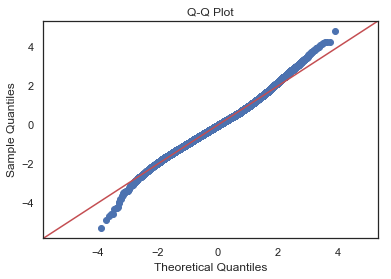

In [135]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
plt.title("Q-Q Plot")
fig.show()

# Final Model

In [136]:
predictors_int = sm.add_constant(predictors)
model = sm.OLS(target,predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     4652.
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        06:24:41   Log-Likelihood:                -1773.6
No. Observations:               21597   AIC:                             3577.
Df Residuals:                   21582   BIC:                             3697.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.6935      0.004   1452.698      0.000       5.686       5.701
bathrooms             0.0164      0.003      5.585      0.000       0.011       0.022
sqft_lot              0.0208      0.003      8.067      0.000       0.016       0.026
floors                0.0148      0.002      6.207      0.000       0.010       0.020
view                  0.0611      0.002     29.697      0.000       0.057       0.065
condition             0.0705      0.002     37.763      0.000       0.067       0.074
grade                 0.1662      0.003     52.302      0.000       0.160       0.172
sqft_above            0.1354      0.004     35.633      0.000       0.128       0.143
lat                   0.2035      0.002    110.494      0.000       0.200       0.207
sqft_living15         0.0674      0.003     22.658      0.000       0.062       0.073
sqft_lot15           -0.0112      0.003     -4.303      0.000      -0.016      -0.006
waterfront_0.0        1.7714      0.007    248.667      0.000       1.757       1.785
waterfront_1.0        2.1564      0.017    127.607      0.000       2.123       2.190
waterfront_nan        1.7657      0.008    226.254      0.000       1.750       1.781
yr_renovated_0.0      2.7459      0.004    624.406      0.000       2.737       2.755
yr_renovated_1.0      2.9475      0.006    482.022      0.000       2.936       2.960
sqft_basement_0.0     2.7672      0.003    937.948      0.000       2.761       2.773
sqft_basement_1.0     2.9263      0.003    940.380      0.000       2.920       2.932
==============================================================================
Omnibus:                      392.557   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              619.892
Skew:                           0.183   Prob(JB):                    2.47e-135
Kurtosis:                       3.744   Cond. No.                     5.84e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.27e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Explanation of Final Model

-The R2 is .751 which seems pretty good
More specifically this means that our model explains about 75% of the variance of the price of houses.  The other 25% is explained by error

-The adj. R2 is also .751.  
This is good to see because adj. R2 takes into account whether adding additional features outweighs the cost of the complexification that each additional variable adds to the model.  Because our R2 is the same as the adj R2, it seems we have only added varaiables that at least have a slight affect on price

-The skew value is .183
The general rule of thumb is that skewness values between -.5 and .5 indicate fairly symmetrical data.  Since .183 is contained in that range we can say that our data is likely fairly good symmetrically

-The kurtosis value is 3.744
A kurtosis value greater than 3 indicates we have Leptokurtic.  Leptokurticity indicates a higher and sharper peak to the data.  This also tends to coincide with data that has a lot of outliers.  Given that a value of 3 is generally considered a good balance between lepto and platy-kurticity, our 3.744 value doesn't seem like it would be too terrible.  Maybe only kurtosis values of greater than 4 are known has having major problems with kurtosis in your data

# Interpret The Data

The whole goal of this process was to find out which variables given were a good predicter of the housing prices of King's County

We started out with 20 possible predictors to use with our model.  But it was really only 17 as id, date, and zipcode (in my opinion) were not meant to be used as predictors like the other variables potentially could be.

So out of the 17 possible variables we ended up selecting only 10 to use as they were given.  In our opinion, those 10 were the only ones that were a good predicter of the housing prices.  The other 7 would not be helpful (enough) if we needed to predict the price of a house in King's County in the future

But our model has a total of 17 predictor variables and that is because in addition the 10 we took directly from the original dataset, 3 of the original variables were changed into categorical dummy variables (0s and 1s) that resulted in 7 total additional categorical variables.

It is important to note that during the process of creating this multivariable linear regression model that could help us predict housing prices, some of the data was altered to craft a better model.  The following changes were made:

- the target data series (price) was log-transformed to improve skew
- each feature variable was set to the same scale using z-score normalization

# Coefficients

The very best predicter of price, according to Recursive Feature Selection, was the categorical variable: waterfront_nan 

This is a variable I manufactured from the waterfront column in the original dataset. It was made using the approximately 2300 data values marked as 'nan'.  My best guess is those 'nan' values were used by the data collector when it could not be determined if a house was a 'waterfront' property.  I personally would be surprised if any of those 'nan' rows were actually houses that were on the waterfront because 1. it's usually not a mystery if a house is near the water and 2. a house being on the waterfront was a rare occurence in this dataset

It's coefficient is -.3907.  This means it has a negative relationship with the target variable.  Meaning that a yes for waterfront_nan would lead to a decrease in price.  This sort of makes sense because we all know how coveted waterfront property is.  And since we're assuming those waterfront_nan values probably mean the house is not on the water, a yes for waterfront_nan would be bad for the price of the house.

price is going to go down by .3907 for each waterfront_nan yes (1 value)

-----------------------------------------------------------------------------------------------------------------------

The next 2 best predictors are the other 2 waterfront categorical columns.  Once again this isn't too surprising given how popular it is to live near the water

-----------------------------------------------------------------------------------------------------------------------

The 4th best predictive feature, and our 1st of the continuous type, is: grade 

The coefficient is .1662.  The relationship between price and grade is positive.  Meaning the higher the number the higher the price.  This is important to note since this data is a value determined by King's County and we didn't have much information about it.  Heck, a lower number could have meant a 'better' grade for all we knew.  After all, 1st place is generally considered better than 2nd place

we expect price to increase by .1662 for each additional grade unit

------------------------------------------------------------------------------------------------------------------------

The last feature I'll look at is: sqft_above

This variable measures the square footage of the house apart from the basement.  I found this feature to also have noticeable influence on the target variable, though not as much as the 2 previously described.  

Once again, when looking at this from a real-world perspective, it makes sense that this variable would be correlated with price.  People generally like to have more room in their house rather than less room.

The coefficient value is: .1354
Meaning that we would expect price to increase by .1354 for each additional unit of sqft_above